In [3]:
import pandas as pd
import numpy as np
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt

# ✅ 1. 빙글 구간 제거 + 스플라인 보간 함수
def clean_and_spline_interpolate(df):
    df = df.dropna(subset=['LAT', 'LON', 'COG', 'HEADING', 'SPEED']).copy()
    
    # 변화량 계산
    df['DELTA_COG'] = df['COG'].diff().abs()
    df['DELTA_HEADING'] = df['HEADING'].diff().abs()

    # 빙글 조건: 속도 < 1.0 and 방향 변화량 > 30
    df['LOOP'] = ((df['SPEED'] < 1.0) &
                  ((df['DELTA_COG'] > 30) | (df['DELTA_HEADING'] > 30))).astype(int)

    # 이상 구간 제거
    df_cleaned = df[df['LOOP'] == 0].copy().reset_index(drop=True)
    df_cleaned['t'] = np.arange(len(df_cleaned))  # 시퀀스 인덱스

    # 스플라인 보간 적용 (위치만)
    spline_lat = UnivariateSpline(df_cleaned['t'], df_cleaned['LAT'], s=0)
    spline_lon = UnivariateSpline(df_cleaned['t'], df_cleaned['LON'], s=0)

    df_cleaned['LAT_SPLINE'] = spline_lat(df_cleaned['t'])
    df_cleaned['LON_SPLINE'] = spline_lon(df_cleaned['t'])

    return df, df_cleaned

# ✅ 2. 시각화 함수
def plot_spline_comparison(df_orig, df_cleaned):
    plt.figure(figsize=(12, 6))

    # 원본 경로
    plt.plot(df_orig['LON'], df_orig['LAT'], label='원본 경로', color='lightblue', alpha=0.5)

    # 빙글 지점
    loop_df = df_orig[df_orig['LOOP'] == 1]
    plt.scatter(loop_df['LON'], loop_df['LAT'], color='red', label='빙글 지점', s=20)

    # 스플라인 보간 경로
    plt.plot(df_cleaned['LON_SPLINE'], df_cleaned['LAT_SPLINE'],
             label='스플라인 보간 경로', color='green', linewidth=2)

    plt.title("스플라인 보간 기반 항로 정제")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [9]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정 (Windows: Malgun Gothic)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스(-) 깨짐 방지

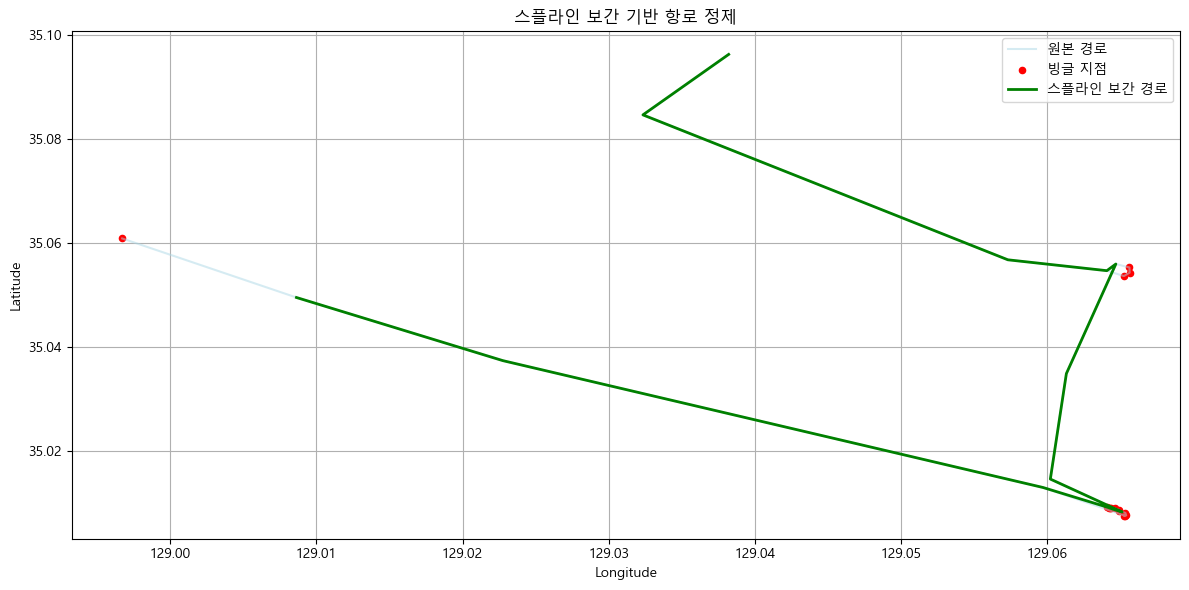

In [11]:
df = pd.read_csv("./dataset/KRKCN/ca8ed98c-9011-34bd-8d76-97bc262ede93.csv")
df_orig, df_spline = clean_and_spline_interpolate(df)
plot_spline_comparison(df_orig, df_spline)